In [6]:
!pip install -qq datasets
!pip install stanza
!pip install transformers torch pandas

In [2]:
import stanza
from datasets import load_dataset
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

In [3]:
# Download and initialize the Slovak Stanza model
stanza.download('sk')
nlp = stanza.Pipeline('sk')

# Load the dataset
dataset = load_dataset("miriamsventova/harrypotter_svk_subtitles")

# Combine text and movie columns into a dataframe
df = pd.DataFrame({"movie": dataset["train"]["movie"], "text": dataset["train"]["text"]})

# Function to extract only nouns from the text
def extract_nouns(text, nlp):
    doc = nlp(text)
    nouns = [word.text for sentence in doc.sentences for word in sentence.words if word.upos == "NOUN"]
    return " ".join(nouns)

2024-11-08 21:00:21 INFO: Downloaded file to /teamspace/studios/this_studio/stanza_resources/resources.json
2024-11-08 21:00:21 INFO: Downloading default packages for language: sk (Slovak) ...


2024-11-08 21:00:23 INFO: Downloaded file to /teamspace/studios/this_studio/stanza_resources/sk/default.zip
2024-11-08 21:00:24 INFO: Finished downloading models and saved to /teamspace/studios/this_studio/stanza_resources
2024-11-08 21:00:24 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-11-08 21:00:24 INFO: Downloaded file to /teamspace/studios/this_studio/stanza_resources/resources.json
2024-11-08 21:00:24 INFO: Loading these models for language: sk (Slovak):
| Processor | Package      |
----------------------------
| tokenize  | snk          |
| mwt       | snk          |
| pos       | snk_nocharlm |
| lemma     | snk_nocharlm |
| depparse  | snk_nocharlm |

2024-11-08 21:00:24 INFO: Using device: cpu
2024-11-08 21:00:24 INFO: Loading: tokenize
2024-11-08 21:00:25 INFO: Loading: mwt
2024-11-08 21:00:25 INFO: Loading: pos
2024-11-08 21:00:25 INFO: Loading: lemma
2024-11-08 21:00:25 INFO: Loading: depparse
2024-11-08 21:00:25 INFO: Done loading processors!


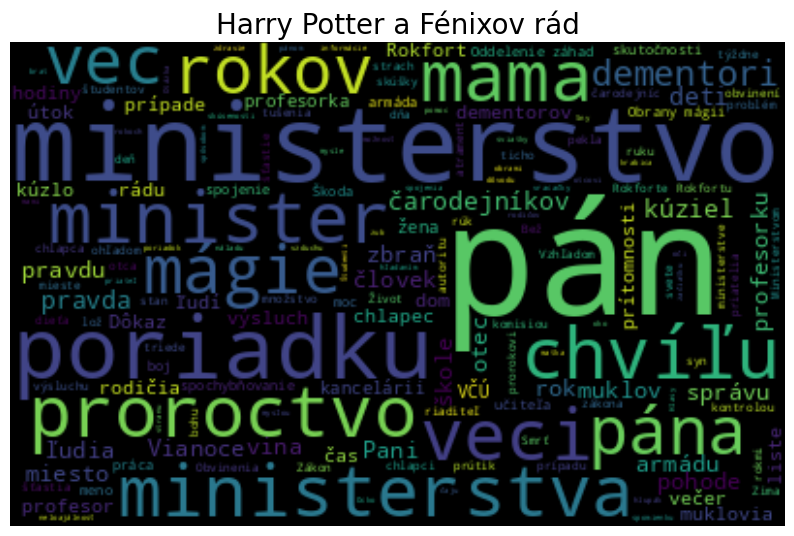

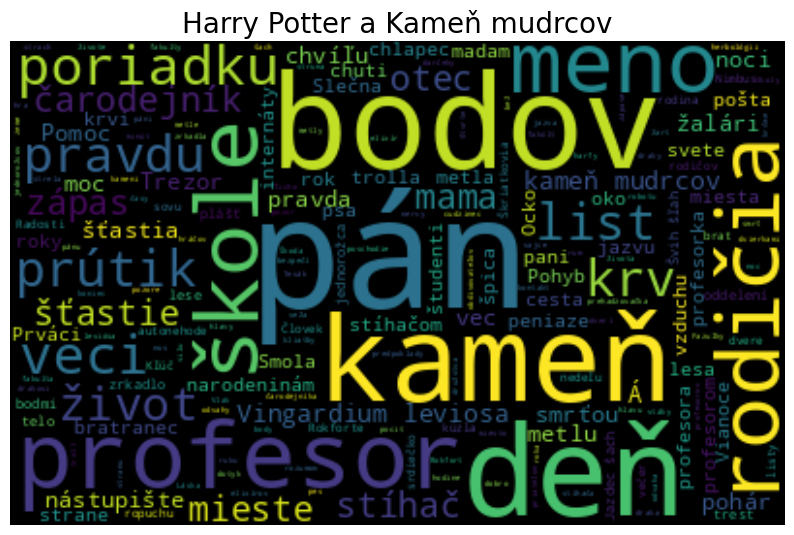

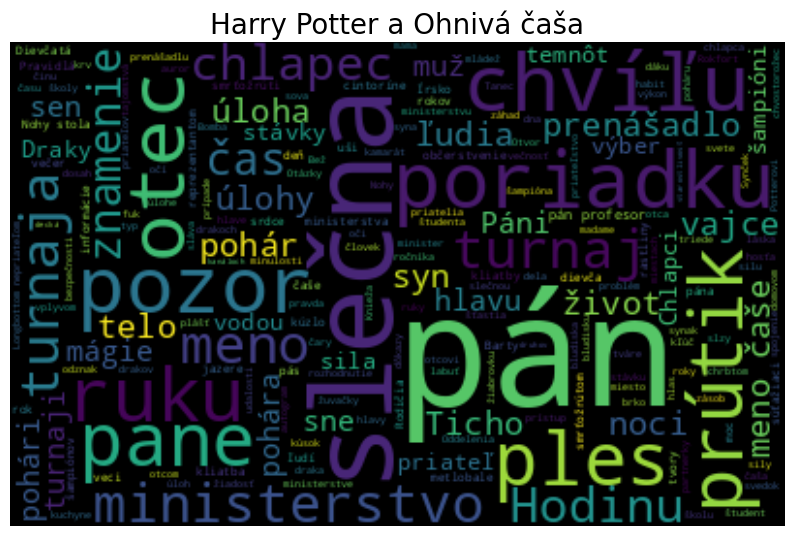

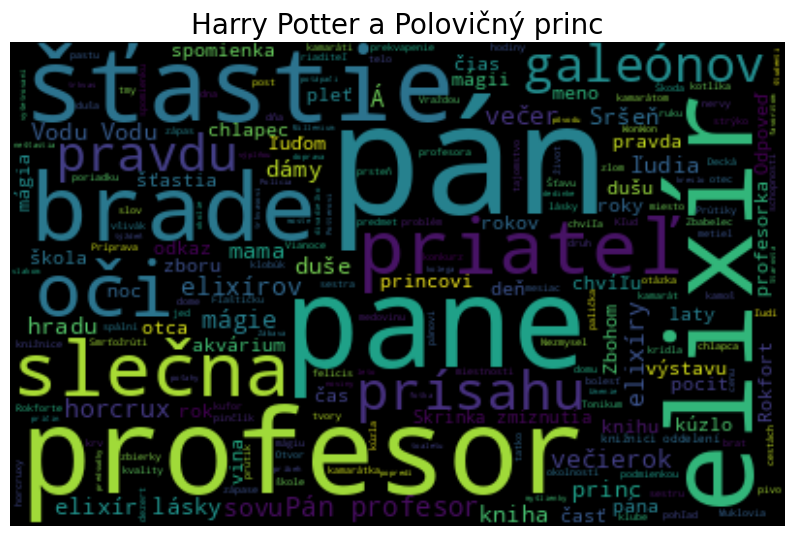

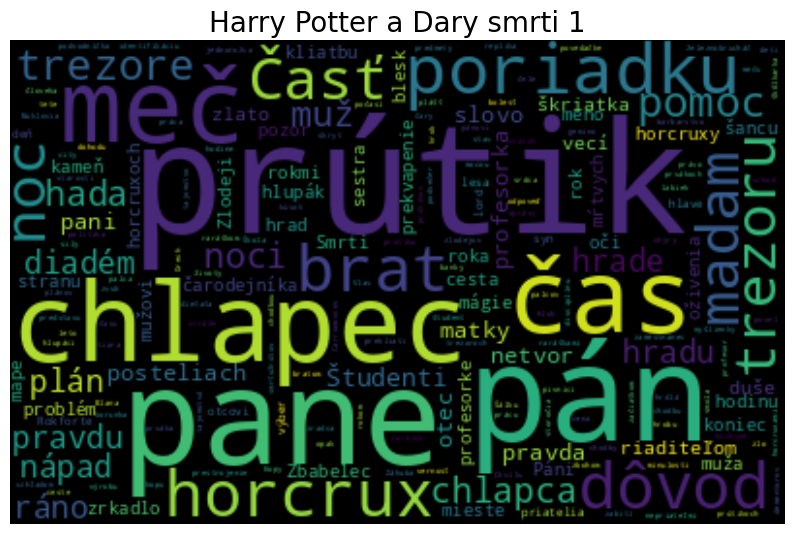

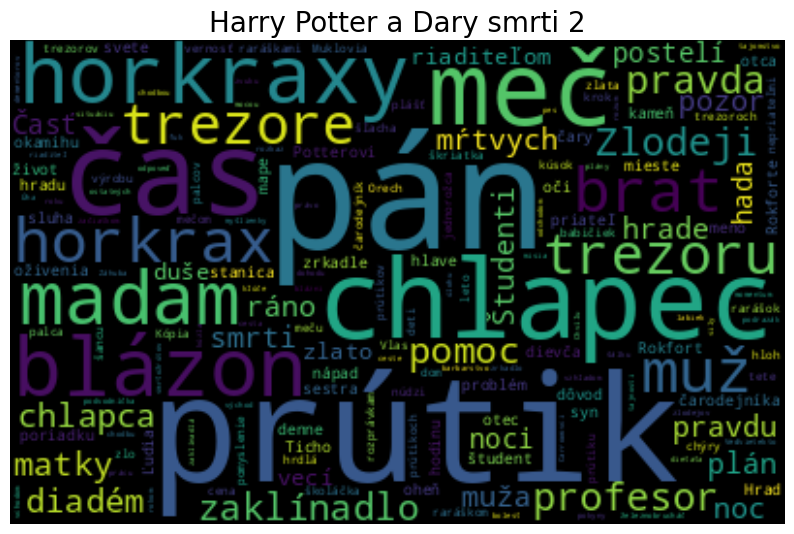

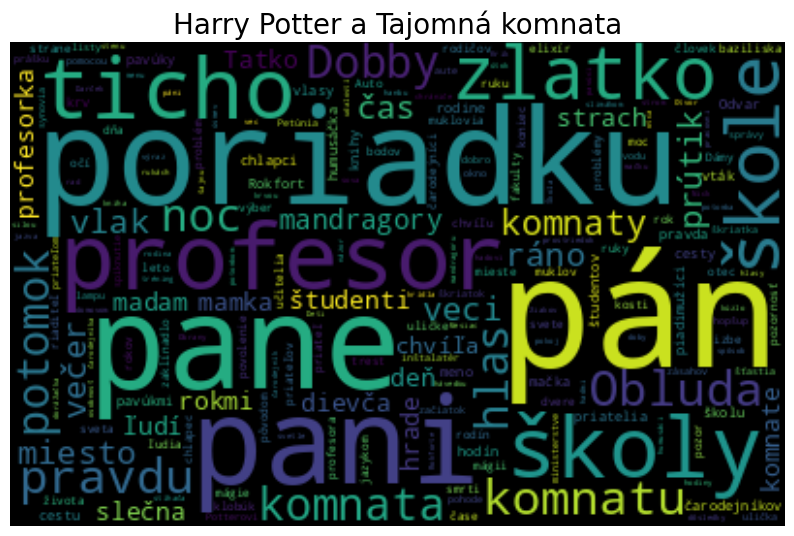

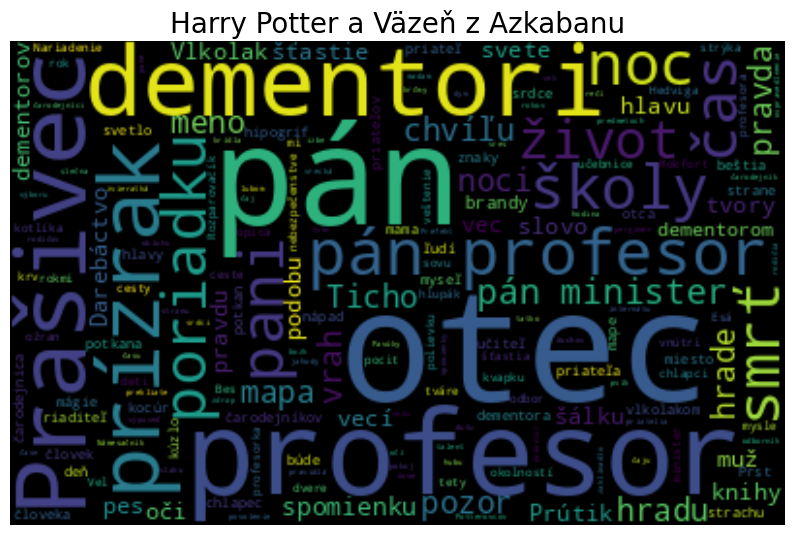

In [5]:
# Loop through each unique movie and create a word cloud for nouns only
for movie in df["movie"].unique():
    # Filter text for the specific movie
    movie_text = " ".join(df[df["movie"] == movie]["text"])
    
    # Extract only nouns from the text
    nouns_text = extract_nouns(movie_text, nlp)
    
    # Create the word cloud for nouns only
    wordcloud = WordCloud(
        max_font_size=80, 
        width=400, 
        height=250, 
        background_color="black"
    ).generate(nouns_text)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{movie}", fontsize=20)
    plt.show()


In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from datasets import load_dataset
import pandas as pd

# Load Emotion Model: Toshifumi/bert-base-multilingual-cased-finetuned-emotion
emotion_model_name = "Toshifumi/bert-base-multilingual-cased-finetuned-emotion"
emotion_tokenizer = AutoTokenizer.from_pretrained(emotion_model_name)
emotion_model = AutoModelForSequenceClassification.from_pretrained(emotion_model_name)

# Load Sentiment Model: cardiffnlp/twitter-xlm-roberta-base-sentiment-multilingual
sentiment_model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment-multilingual"
sentiment_tokenizer = AutoTokenizer.from_pretrained(sentiment_model_name)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(sentiment_model_name)

# Function to predict emotion
def predict_emotion(text):
    inputs = emotion_tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding=True)
    with torch.no_grad():
        outputs = emotion_model(**inputs)
    probabilities = F.softmax(outputs.logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    confidence = probabilities[0, predicted_class].item()
    emotion_labels = ["anger", "joy", "sadness", "fear", "neutral", "surprise"]
    return emotion_labels[predicted_class], confidence

# Function to predict sentiment
def predict_sentiment(text):
    inputs = sentiment_tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding=True)
    with torch.no_grad():
        outputs = sentiment_model(**inputs)
    probabilities = F.softmax(outputs.logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    confidence = probabilities[0, predicted_class].item()
    sentiment_labels = ["negative", "neutral", "positive"]  # Multilingual sentiment classes
    return sentiment_labels[predicted_class], confidence

# Load the dataset from Hugging Face
dataset = load_dataset("miriamsventova/harrypotter_svk_subtitles")

# Convert the dataset to a DataFrame
df = pd.DataFrame(dataset["train"])

# Apply both Emotion and Sentiment predictions
emotions = []
sentiments = []
emotion_confidences = []
sentiment_confidences = []

for text in df['text']:
    # Predict Emotion
    emotion, emotion_confidence = predict_emotion(text)
    emotions.append(emotion)
    emotion_confidences.append(emotion_confidence)
    
    # Predict Sentiment
    sentiment, sentiment_confidence = predict_sentiment(text)
    sentiments.append(sentiment)
    sentiment_confidences.append(sentiment_confidence)

# Add the predictions to the DataFrame
df['Predicted Emotion'] = emotions
df['Emotion Confidence Score'] = emotion_confidences
df['Predicted Sentiment'] = sentiments
df['Sentiment Confidence Score'] = sentiment_confidences

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [10]:
# Display a few random rows with the selected columns
random_rows = df.sample(n=12)[['movie', 'text', 'Predicted Emotion', 'Emotion Confidence Score', 'Predicted Sentiment', 'Sentiment Confidence Score']]

# Display the random rows in a nice format
import IPython.display as display
display.display(random_rows)

# Optionally, save to a new CSV file
random_rows.to_csv("harrypotter_sentiment_emotion_analysis.csv", index=False)

,movie,text,Predicted Emotion,Emotion Confidence Score,Predicted Sentiment,Sentiment Confidence Score
1096,Harry Potter a Polovičný princ,"Aj ja teba! Čo vy tu? Ani sa nepýtaj, aký dlhý...",joy,0.640258,positive,0.876559
1085,Harry Potter a Polovičný princ,Je odporný. Počula si o kúzle Sectumsempra? Ni...,fear,0.354034,negative,0.965242
106,Harry Potter a Fénixov rád,"Šestnásť, šestnásť rokov som tu strávila. Rokf...",joy,0.498475,negative,0.920816
2171,Harry Potter a Väzeň z Azkabanu,Poďte. Inde je už obsadené. Kto to môže byť? P...,joy,0.667127,neutral,0.794383
304,Harry Potter a Kameň mudrcov,"Sklapni, Dursley, ty hlava dubová. Naposledy s...",joy,0.521992,negative,0.978321
1295,Harry Potter a Polovičný princ,Partis Temporus! Všetci do spální! Okamžite. M...,joy,0.364833,neutral,0.717720
1446,Harry Potter a Dary smrti 1,"Komu je skutočne verný? Vám, samozrejme, môj p...",joy,0.782444,negative,0.974626
472,Harry Potter a Kameň mudrcov,"Tak si ho skús. Zmizlo mi telo! Viem, čo to je...",anger,0.293113,negative,0.977579
242,Harry Potter a Fénixov rád,"Tak, ako sa dostaneme do Londýna? Predsa polet...",joy,0.648502,positive,0.941961
1476,Harry Potter a Dary smrti 1,Zomieranie? Je to rýchlejšie ako zaspať. Si...,anger,0.899796,negative,0.984450
